In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "../healthcare_dataset.csv"

df=pd.read_csv(file_path)

df['Date of Admission']=pd.to_datetime(df['Date of Admission'])

df = df.sort_values("Date of Admission")
daily_admissions = df.groupby("Date of Admission").size().rename("admissions")

daily_admissions = daily_admissions.asfreq("D", fill_value=0)

print(daily_admissions.head())
print(daily_admissions.index.freq)

Date of Admission
2019-05-08    27
2019-05-09    38
2019-05-10    17
2019-05-11    25
2019-05-12    36
Freq: D, Name: admissions, dtype: int64
<Day>


In [9]:
train_size = int(len(daily_admissions) * 0.7)

train = daily_admissions.iloc[:train_size]
test  = daily_admissions.iloc[train_size:]

print("Train:", train.index.min(), "to", train.index.max(), "len=", len(train))
print("Test :", test.index.min(),  "to", test.index.max(),  "len=", len(test))

Train: 2019-05-08 00:00:00 to 2022-11-05 00:00:00 len= 1278
Test : 2022-11-06 00:00:00 to 2024-05-07 00:00:00 len= 549


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        admissions   No. Observations:                 1278
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -4109.676
Date:                           Tue, 06 Jan 2026   AIC                           8229.351
Time:                                   14:29:47   BIC                           8255.081
Sample:                               05-08-2019   HQIC                          8239.017
                                    - 11-05-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8944      0.126      7.099      0.000       0.647       1.141
ma.L1         -0.8905      0.130     -6.833

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

sarima_forecast = sarima_fit.forecast(steps=len(test))
sarima_pred = sarima_forecast  # same thing, just naming

rmse = np.sqrt(mean_squared_error(test, sarima_pred))
mae  = mean_absolute_error(test, sarima_pred)
mape = np.mean(np.abs((test - sarima_pred) / test)) * 100
accuracy = 100 - mape

print("SARIMA performance on TEST set:")
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape, "%")
print("Accuracy (100 - MAPE):", accuracy, "%")

SARIMA performance on TEST set:
RMSE: 6.100724289204465
MAE : 4.872438554370302
MAPE: 16.845940939788857 %
Accuracy (100 - MAPE): 83.15405906021114 %


In [12]:
sarima_df = pd.DataFrame({
    "date": test.index,
    "actual": test.values,
    "sarima_pred": sarima_pred.values
})

sarima_df.to_csv("../70_30 split/predictions/sarima_predictions.csv", index=False)

print("SARIMA predictions saved successfully.")

SARIMA predictions saved successfully.


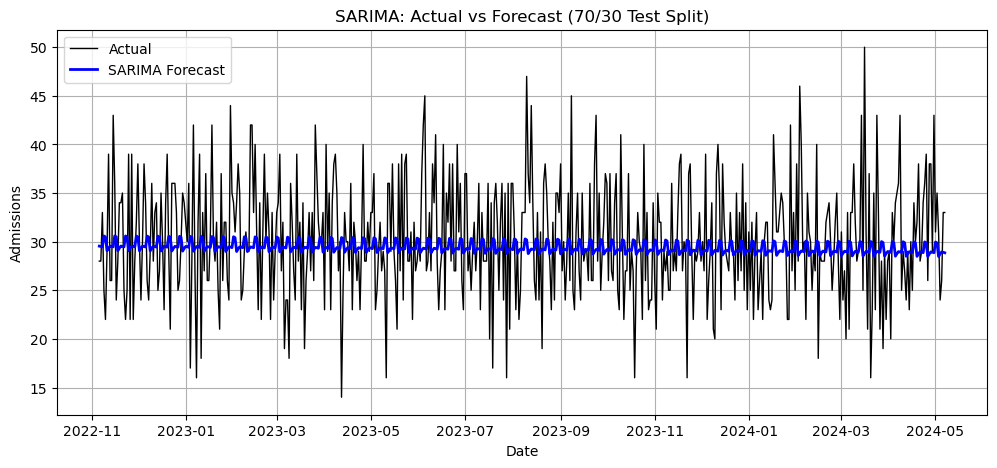

In [13]:
y_test = test.sort_index()
sarima_pred = pd.Series(sarima_pred, index=y_test.index)

# Plot SARIMA vs Actual (70/30)
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual", color="black", linewidth=1)
plt.plot(sarima_pred.index, sarima_pred.values, label="SARIMA Forecast", color="blue", linewidth=2)

plt.title("SARIMA: Actual vs Forecast (70/30 Test Split)")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
#Rolling Series Model

series = daily_admissions.sort_index()

train_series = series.iloc[:train_size]
test_series  = series.iloc[train_size:]

history = train_series.copy()
rolling_preds = []

for t in range(len(test_series)):
    model = SARIMAX(
        history,
        order=(1,0,1),
        seasonal_order=(1,0,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    model_fit = model.fit(disp=False)
    
    y_pred = model_fit.forecast(steps=1)
    rolling_preds.append(y_pred.iloc[0])
    
    # add true value to history
    history = pd.concat([history, test_series.iloc[t:t+1]])

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

In [ ]:
sarima_rolling_pred = pd.Series(
    rolling_preds,
    index=test_series.index,
    name="sarima_rolling"
)

y_test = test_series

In [ ]:
rmse = np.sqrt(mean_squared_error(test_series, rolling_pred_series))
mae  = mean_absolute_error(test_series, rolling_pred_series)
mape = np.mean(np.abs((test_series - rolling_pred_series) / test_series)) * 100
accuracy = 100 - mape

print("Rolling SARIMA performance:")
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape)
print("Accuracy (100 - MAPE):", accuracy)

In [ ]:
# Plot Actual vs Rolling SARIMA
plt.figure(figsize=(12,5))
plt.plot(test_series.index, test_series, label="Actual", color="black")
plt.plot(sarima_rolling_pred.index, sarima_rolling_pred, 
         label="Rolling SARIMA", color="blue", alpha=0.8)

plt.title("Rolling SARIMA vs Actual (Test Period)")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.show()

In [ ]:
sarima_rolling_df = pd.DataFrame({
    "date": y_test.index,
    "actual": y_test.values,
    "sarima_rolling_pred": sarima_rolling_pred.values
})

sarima_rolling_df.to_csv("../70_30 split/predictions/sarima_rolling_predictions.csv", index=False)

print("SARIMA rolling predictions saved successfully.")


In [10]:
actual_df = pd.DataFrame({
    "date": y_test.index,
    "actual": y_test.values
})

actual_df.to_csv("../70_30 split/predictions/actual.csv", index=False)

NameError: name 'y_test' is not defined